# Setup inicial

In [1]:
# Paths & URLs

import os

# Directorio base
#PATH_BASE = '/content/drive/MyDrive/proximity'
#PATH_BASE = 'C:\\Users\\User\\Documents\\Proyecto Proximity'
PATH_BASE = 'E:\\files\\Documents\\Proyecto Proximity'
#PATH_BASE = '/dataChivo/batch_01/bigdata_02/datareleases/'
USER_HOME_PATH = 'E:\\files\\Documents\\Proyecto Proximity'
#USER_HOME_PATH = '/dataChivo/jpmunoz/'

# Data release 70
DATA_RELEASE_PATH = os.path.join(PATH_BASE, 'datalake_sorted')
DR70_PATH = os.path.join(PATH_BASE, 'DR70')
DR70_LABELS_PATH = os.path.join(DR70_PATH, 'labels.csv')

# Data release 217
DR217_PATH = os.path.join(PATH_BASE, 'DR217')
DR217_CT_PATH = os.path.join(DR217_PATH, 'DR217_studies')
# Used for normalization of the intensity values for each CT
DR217_CT_HISTOGRAM_LANDMARKS_PATH = os.path.join(DR217_PATH, 'DR217_histogram_landmarks.npy')
DR217_LABELS_PATH = os.path.join(DR217_PATH, 'DR217_labels.csv')
# Embeddings ResNet18 DR217
DR217_RESNET_EMBEDDINGS_PATH = os.path.join(DR217_PATH, 'DR217_resnet18_embeddings_v2')
DR217_PREPROCESSED_PATH = os.path.join(DR217_PATH, 'DR217_preprocessed')
DR217_PREPROCESSED_DOWNSIZED_PATH = os.path.join(DR217_PATH, 'DR217_preprocessed_downsized')


# Data release 2156
DR2156_DATARELEASE_PATH = os.path.join(PATH_BASE, 'DR2156')
DR2156_DATARELEASE_CT_PATH = os.path.join(DR2156_DATARELEASE_PATH, 'DR2156_studies')
DR2156_DATARELEASE_LABELS_PATH = os.path.join(DR2156_DATARELEASE_PATH, 'DR2156_labels', 'DR2156_labels.csv')


#DR2156_DATARELEASE_PATH = os.path.join(USER_HOME_PATH, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_DICOM')
#DR2156_DATARELEASE_PATH = os.path.join(PATH_BASE, 'chest_ct_retrieval', 'data', 'DR2156')
#DR2156_DATARELEASE_CT_PATH = os.path.join(DR2156_DATARELEASE_PATH, 'DR2156_DICOM', 'DR2156_studies')
#DR2156_DATARELEASE_LABELS_PATH = os.path.join(DR2156_DATARELEASE_PATH, 'DR2156_DICOM', 'DR2156_labels', 'DR2156_labels.csv')
# Embeddings ResNet18 DR2156 con dimensiones 300x300x300
DR2156_300_RESNET_EMBEDDINGS_PATH = os.path.join(PATH_BASE, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_300_resnet18_embeddings')
DR2156_300_PREPROCESSED_PATH = os.path.join(PATH_BASE, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_300_preprocessed')
DR2156_300_PREPROCESSED_ZARR_PATH = os.path.join(PATH_BASE, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_300_preprocessed_zarr')
DR2156_300_PREPROCESSED_INT8_PATH = os.path.join(USER_HOME_PATH, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_300_preprocessed_int8')

# Embeddings ResNet18 DR2156 con dimensiones 512x512x300
DR2156_512_RESNET_EMBEDDINGS_PATH = os.path.join(USER_HOME_PATH, 'experimentos', 'datasets', 'DR2156', 'DR2156_512_resnet18_embeddings')
DR2156_512_PREPROCESSED_PATH = os.path.join(USER_HOME_PATH, 'experimentos', 'datasets', 'DR2156', 'DR2156_512_preprocessed')


DR2156_270_PREPROCESSED_UINT8_PATH = os.path.join(USER_HOME_PATH, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_270_preprocessed_uint8')

# CTs in Nibabel format
CT_NIBABEL_PATH = os.path.join(PATH_BASE, 'DR70', 'CTs')
CT_NIBABEL_ZERO_PADDED_PATH = os.path.join(PATH_BASE, 'DR70', 'CTs', 'zero_padded')

# Embeddings visuales de CTs
CT_EMBEDDINGS_PATH = DATA_RELEASE_PATH + '/visual_embeddings'


# Etiquetas de los CTs del data release actual
#CT_LABELS_CSV_PATH = DATA_RELEASE_PATH + '/labels.csv'

# Data release (CTs + etiquetas) organizados en un DataFrame
CT_DATASET_DF_HDF_PATH = os.path.join(PATH_BASE, 'dataset_df.h5')
CT_DATASET_DF_PICKLE_PATH = os.path.join(PATH_BASE, 'dataset_df.pickle')

# URLs de modelos visuales
RESNET18_URL = 'microsoft/resnet-18'

# Path que contiene los resnet50 embeddings de CTs del data release actual
CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18')
CT_RESNET18_EMBEDDINGS_PATH_ZERO_PADDED = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18', 'zero_padded')
CT_RESNET18_EMBEDDINGS_PATH_NN_INTERPOLATED = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18', 'nn_interpolated')

In [83]:
import os
import struct
import zlib
from tensorboard.compat.proto import event_pb2
from tensorboard.summary.writer.event_file_writer import EventFileWriter


def _unmask_crc(masked_crc):
    """Unmask a masked CRC-32C value (per TFRecord format)."""
    mask_delta = 0xa282ead8
    return ((masked_crc - mask_delta) & 0xFFFFFFFF) ^ (((masked_crc - mask_delta) & 0xFFFFFFFF) >> 15)


def _crc32c(data):
    """Compute CRC32C checksum."""
    import crc32c  # pip install crc32c
    return crc32c.crc32c(data)


def read_event_file(file_path):
    """Generator yielding Event protos from a TFRecord file without TF."""
    with open(file_path, "rb") as f:
        while True:
            header = f.read(8)  # uint64 length
            if not header:
                break
            length, = struct.unpack("<Q", header)

            f.read(4)  # masked CRC of length (ignored)

            data = f.read(length)  # serialized Event
            f.read(4)  # masked CRC of data (ignored)

            event = event_pb2.Event()
            event.ParseFromString(data)
            yield event


def merge_event_files(file1, file2, output_file):
    """Merge two TensorBoard event files chronologically into one."""
    events1 = list(read_event_file(file1))
    events2 = list(read_event_file(file2))
    all_events = sorted(events1 + events2, key=lambda e: e.wall_time)

    writer = EventFileWriter(logdir=os.path.dirname(output_file),
                             filename_suffix=os.path.basename(output_file))

    for e in all_events:
        writer.add_event(e)
    writer.close()

    print(f"Merged {len(events1)} + {len(events2)} events into {output_file}")


# Example:
# merge_event_files("file1.tfevents", "file2.tfevents", "merged.tfevents")


In [84]:
from tensorboard.backend.event_processing import event_accumulator

# Path to your TensorBoard events file
bce_microf1_events_file_path = "E:\\files\Documents\Proyecto Proximity\chest_ct_retrieval\\runs_bce-microf1\\run_20250809_1803\logs\\run_bce-microf1\events.out.tfevents.run_bce-microf1.0"
post_triplets_events_file_path = "E:\\files\Documents\Proyecto Proximity\chest_ct_retrieval\\runs_bce-microf1\\run_20250809_1803\logs\\run_post_triplets\events.out.tfevents.post_triplets.0"
merged_events_file_path = "E:\\files\Documents\Proyecto Proximity\chest_ct_retrieval\\runs_bce-microf1\\run_20250809_1803\logs\\merged_run\events.out.tfevents.merged_run.0"

merge_event_files(
    file1=bce_microf1_events_file_path,
    file2=post_triplets_events_file_path,
    output_file=merged_events_file_path,
    #step_offset=None  # Automatically offset steps to avoid overlaps
)


Merged 21981 + 9421 events into E:\files\Documents\Proyecto Proximity\chest_ct_retrieval\runs_bce-microf1\run_20250809_1803\logs\merged_run\events.out.tfevents.merged_run.0


In [86]:

merged_events_file_path = "E:\\files\Documents\Proyecto Proximity\chest_ct_retrieval\\runs_bce-microf1\\run_20250809_1803\logs\merged_run\events.out.tfevents.1755025297.Laptop.15208.0events.out.tfevents.merged_run.0"


# Load the events file
ea = event_accumulator.EventAccumulator(merged_events_file_path)
ea.Reload()

# Example: Access scalars, images, histograms, etc.
scalars = {tag: ea.Scalars(tag) for tag in ea.Tags()['scalars']}
print("Available scalar tags:", list(scalars.keys()))

# To get scalar values for a specific tag:
# steps, values = zip(*[(e.step, e.value) for e in scalars['your_scalar_tag']])

Available scalar tags: ['training_loss', 'training_mean_average_precision@1', 'training_mean_average_precision@5', 'training_mean_average_precision@10', 'training_NDCG@1', 'training_NDCG@5', 'training_NDCG@10', 'training_precision@1', 'training_precision@5', 'training_precision@10', 'training_recall@1', 'training_recall@5', 'training_recall@10', 'training_f1@1', 'training_f1@5', 'training_f1@10', 'training_macro_f1@1', 'training_macro_f1@5', 'training_macro_f1@10', 'training_mean_average_precision_random@1', 'training_mean_average_precision_random@5', 'training_mean_average_precision_random@10', 'training_NDCG_random@1', 'training_NDCG_random@5', 'training_NDCG_random@10', 'training_precision_random@1', 'training_precision_random@5', 'training_precision_random@10', 'training_recall_random@1', 'training_recall_random@5', 'training_recall_random@10', 'training_f1_random@1', 'training_f1_random@5', 'training_f1_random@10', 'training_macro_f1_random@1', 'training_macro_f1_random@5', 'train

In [96]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_train_val_scalars_with_random_baseline_and_phases(
    ea,
    train_tags,
    val_tags,
    title,
    xlabel,
    ylabel,
    train_labels,
    val_labels,
    random_train_tags=None,
    random_val_tags=None,
    phase_split_steps=None,
    phase_labels=None
):
    """
    Plots training/validation scalar series with distinct color groups, optional
    random baselines, and vertical lines marking phase changes.

    Parameters
    ----------
    ea : EventAccumulator
        Loaded EventAccumulator for the events file.
    train_tags : list[str]
        Scalar tags for training metrics.
    val_tags : list[str]
        Scalar tags for validation metrics (same length as train_tags).
    title : str
        Plot title.
    xlabel : str
        X-axis label.
    ylabel : str
        Y-axis label.
    train_labels : list[str]
        Legend labels for training series.
    val_labels : list[str]
        Legend labels for validation series.
    random_train_tags : list[str] or None
        Scalar tags for training random metrics (optional).
    random_val_tags : list[str] or None
        Scalar tags for validation random metrics (optional).
    phase_split_steps : list[int] or None
        Global step values where a phase change occurs.
    phase_labels : list[str] or None
        Labels for each phase change line (must match length of phase_split_steps).
    """
    assert len(train_tags) == len(val_tags), "Train and validation tag lists must have the same length"
    assert len(train_labels) == len(val_labels) == len(train_tags), "Label lists must match tag list lengths"

    n_metrics = len(train_tags)

    # Color maps
    train_cmap = cm.get_cmap('Blues', n_metrics + 1)
    val_cmap = cm.get_cmap('Oranges', n_metrics + 1)

    plt.figure(figsize=(9, 5))

    for i, (train_tag, val_tag) in enumerate(zip(train_tags, val_tags)):
        # --- Train curve ---
        train_events = ea.Scalars(train_tag)
        train_steps, train_values = zip(*[(e.step, e.value) for e in train_events])
        plt.plot(train_steps, train_values, label=train_labels[i], color=train_cmap(i + 1), linewidth=1.5)

        # --- Val curve ---
        val_events = ea.Scalars(val_tag)
        val_steps, val_values = zip(*[(e.step, e.value) for e in val_events])
        plt.plot(val_steps, val_values, label=val_labels[i], color=val_cmap(i + 1), linewidth=1.5)

        # --- Random baseline for training ---
        if random_train_tags and random_train_tags[i]:
            rand_events = ea.Scalars(random_train_tags[i])
            sample_size = len(rand_events)
        else:
            rand_events = ea.Scalars(train_tag)
            sample_size = max(1, int(len(rand_events)*0.2))
            if rand_events:
                rand_values = [e.value for e in rand_events]
                rand_avg = 0.8 * sum(rand_values[:sample_size]) / sample_size
                plt.axhline(y=rand_avg, color=train_cmap(i + 1), linestyle="--", alpha=0.6,
                            label=f"{train_labels[i]} (aleat.)")
        
        # --- Random baseline for validation ---
        if random_val_tags and random_val_tags[i]:
            rand_events = ea.Scalars(random_val_tags[i])
            sample_size = len(rand_events)
        else:
            rand_events = ea.Scalars(val_tag)
            sample_size = max(1, int(len(rand_events)*0.2))
            if rand_events:
                rand_values = [e.value for e in rand_events]
                rand_avg = 0.8* sum(rand_values[:sample_size]) / sample_size
                plt.axhline(y=rand_avg, color=val_cmap(i + 1), linestyle="--", alpha=0.6,
                            label=f"{val_labels[i]} (aleat.)")
        
    # --- Phase change markers ---
    if phase_split_steps:
        for idx, step in enumerate(phase_split_steps):
            plt.axvline(x=step, color="black", linestyle="--", alpha=0.7)
            if phase_labels and idx < len(phase_labels):
                plt.text(step, plt.ylim()[1]*0.95, phase_labels[idx],
                         rotation=90, verticalalignment="top", horizontalalignment="right",
                         fontsize=9, color="black", backgroundcolor="white")
                
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Entrenamiento diferido BCE + MicroF1 -> Triplets

C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\3561250936.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\3561250936.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)


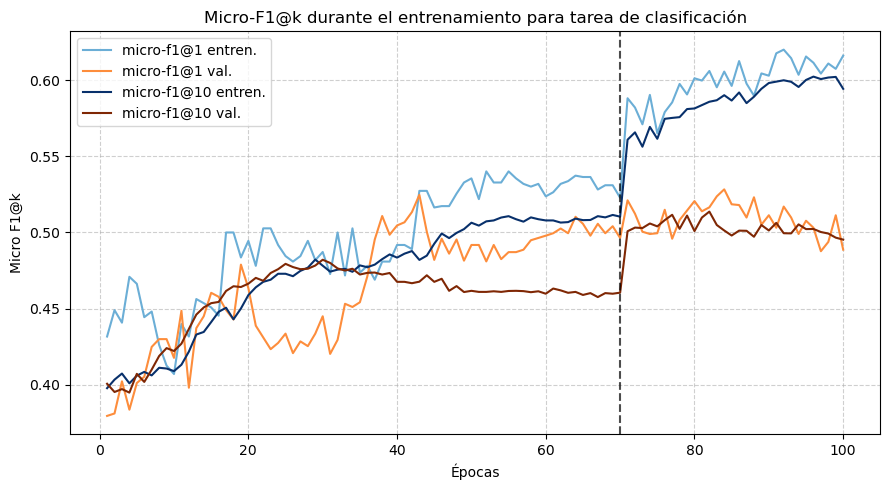

In [95]:
plot_train_val_scalars_with_random_baseline_and_phases(
    ea,
    train_tags=['training_f1@1', 'training_f1@10'],
    val_tags=['validation_f1@1', 'validation_f1@10'],
    title="Micro-F1@k durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="Micro F1@k",
    train_labels=["micro-f1@1 entren.", "micro-f1@10 entren."],
    val_labels=["micro-f1@1 val.", "micro-f1@10 val."],
    random_train_tags=['training_f1_random@1', 'training_f1_random@10'],
    random_val_tags=['validation_f1_random@1', 'validation_f1_random@10'],
    phase_split_steps=[70]
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\3561250936.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\3561250936.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)


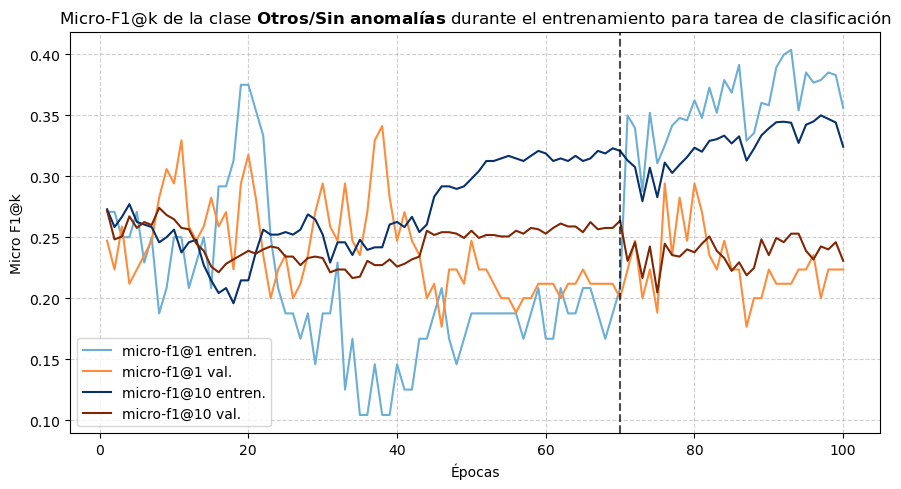

In [97]:
plot_train_val_scalars_with_random_baseline_and_phases(
    ea,
    train_tags=['training_f1_sin_anomalias@1', 'training_f1_sin_anomalias@10'],
    val_tags=['validation_f1_sin_anomalias@1', 'validation_f1_sin_anomalias@10'],
    title="Micro-F1@k de la clase " + r"$\bf{" + "Otros/Sin\ anomalías" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="Micro F1@k",
    train_labels=["micro-f1@1 entren.", "micro-f1@10 entren."],
    val_labels=["micro-f1@1 val.", "micro-f1@10 val."],
    random_train_tags=['training_f1_sin_anomalias_random@1', 'training_f1_sin_anomalias_random@10'],
    random_val_tags=['validation_f1_sin_anomalias_random@1', 'validation_f1_sin_anomalias_random@10'],
    phase_split_steps=[70]
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\3561250936.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\3561250936.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)


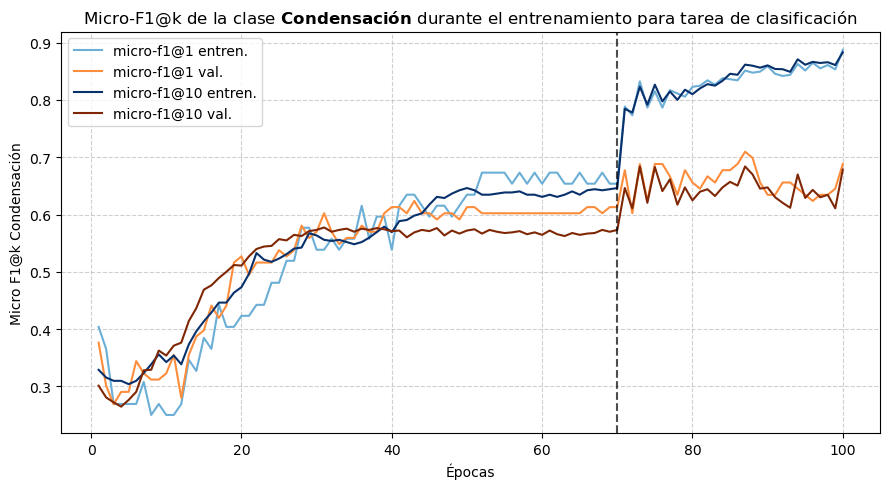

In [98]:
plot_train_val_scalars_with_random_baseline_and_phases(
    ea,
    train_tags=['training_f1_condensacion@1', 'training_f1_condensacion@10'],
    val_tags=['validation_f1_condensacion@1', 'validation_f1_condensacion@10'],
    title="Micro-F1@k de la clase " + r"$\bf{" + "Condensación" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="Micro F1@k Condensación",
    train_labels=["micro-f1@1 entren.", "micro-f1@10 entren."],
    val_labels=["micro-f1@1 val.", "micro-f1@10 val."],
    random_train_tags=['training_f1_condensacion_random@1', 'training_f1_condensacion_random@10'],
    random_val_tags=['validation_f1_condensacion_random@1', 'validation_f1_condensacion_random@10'],
    phase_split_steps=[70]
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\3561250936.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\3561250936.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)


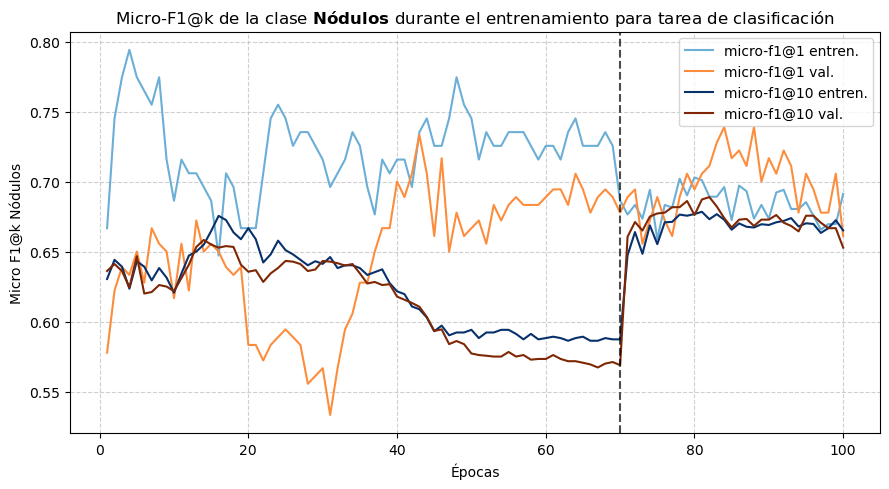

In [99]:
plot_train_val_scalars_with_random_baseline_and_phases(
    ea,
    train_tags=['training_f1_nodulos@1', 'training_f1_nodulos@10'],
    val_tags=['validation_f1_nodulos@1', 'validation_f1_nodulos@10'],
    title="Micro-F1@k de la clase " + r"$\bf{" + "Nódulos" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="Micro F1@k Nódulos",
    train_labels=["micro-f1@1 entren.", "micro-f1@10 entren."],
    val_labels=["micro-f1@1 val.", "micro-f1@10 val."],
    random_train_tags=['training_f1_nodulos_random@1', 'training_f1_nodulos_random@10'],
    random_val_tags=['validation_f1_nodulos_random@1', 'validation_f1_nodulos_random@10'],
    phase_split_steps=[70]
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\3561250936.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\3561250936.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)


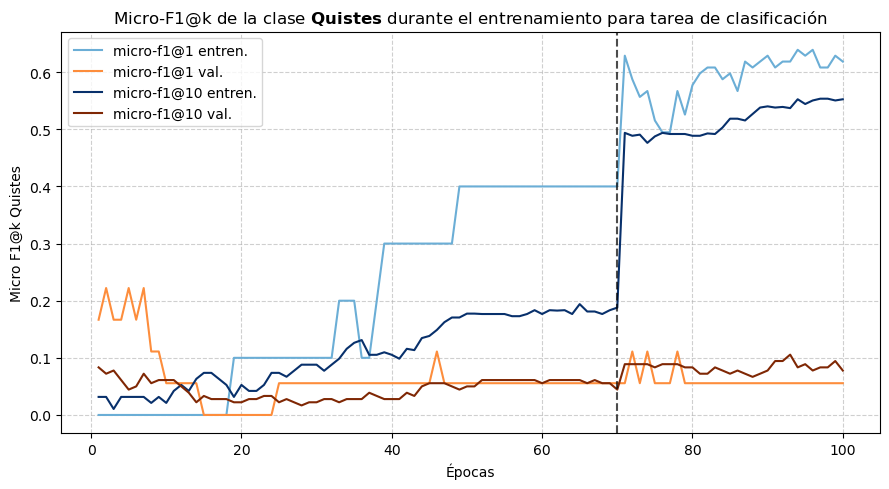

In [100]:
plot_train_val_scalars_with_random_baseline_and_phases(
    ea,
    train_tags=['training_f1_quistes@1', 'training_f1_quistes@10'],
    val_tags=['validation_f1_quistes@1', 'validation_f1_quistes@10'],
    title="Micro-F1@k de la clase " + r"$\bf{" + "Quistes" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="Micro F1@k Quistes",
    train_labels=["micro-f1@1 entren.", "micro-f1@10 entren."],
    val_labels=["micro-f1@1 val.", "micro-f1@10 val."],
    random_train_tags=['training_f1_quistes_random@1', 'training_f1_quistes_random@10'],
    random_val_tags=['validation_f1_quistes_random@1', 'validation_f1_quistes_random@10'],
    phase_split_steps=[70]
)


In [6]:
losses = ['training_loss', 'validation_loss']
micro_f1_1 = ['training_f1@1', 'validation_f1@1']
micro_f1_10 = ['training_f1@10', 'validation_f1@10']
map_1 = ['training_mean_average_precision@1', 'validation_mean_average_precision@1']
map_10 = ['training_mean_average_precision@10', 'validation_mean_average_precision@10']

# Micro-F1

C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)  # blue shades
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)  # orange shades


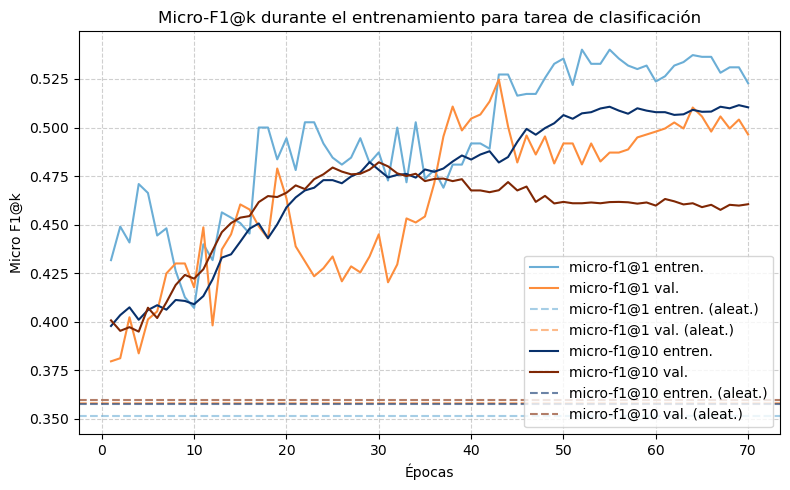

In [40]:
plot_train_val_scalars_with_random_baseline(
    ea,
    train_tags=['training_f1@1', 'training_f1@10'],
    val_tags=['validation_f1@1', 'validation_f1@10'],
    title="Micro-F1@k durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="Micro F1@k",
    train_labels=["micro-f1@1 entren.", "micro-f1@10 entren."],
    val_labels=["micro-f1@1 val.", "micro-f1@10 val."],
    random_train_tags=['training_f1_random@1', 'training_f1_random@10'],
    random_val_tags=['validation_f1_random@1', 'validation_f1_random@10']
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)  # blue shades
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)  # orange shades


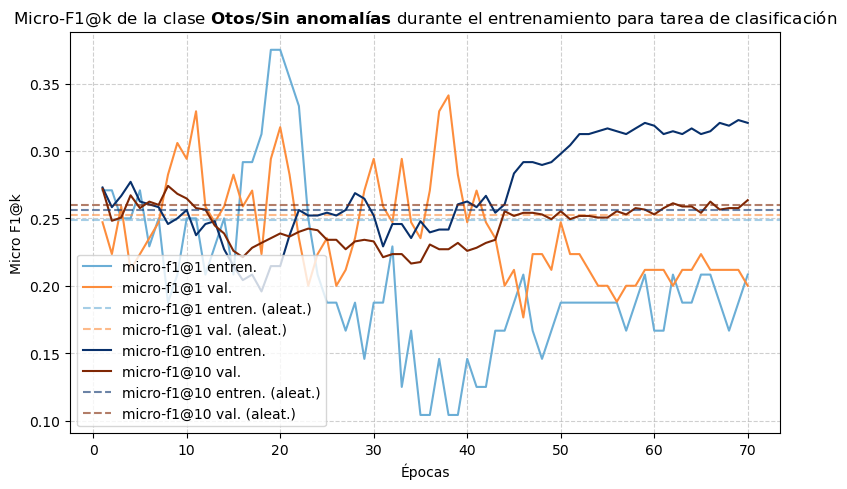

In [41]:
plot_train_val_scalars_with_random_baseline(

    ea,
    train_tags=['training_f1_sin_anomalias@1', 'training_f1_sin_anomalias@10'],
    val_tags=['validation_f1_sin_anomalias@1', 'validation_f1_sin_anomalias@10'],
    title="Micro-F1@k de la clase " + r"$\bf{" + "Otos/Sin\ anomalías" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="Micro F1@k",
    train_labels=["micro-f1@1 entren.", "micro-f1@10 entren."],
    val_labels=["micro-f1@1 val.", "micro-f1@10 val."],
    random_train_tags=['training_f1_sin_anomalias_random@1', 'training_f1_sin_anomalias_random@10'],
    random_val_tags=['validation_f1_sin_anomalias_random@1', 'validation_f1_sin_anomalias_random@10']
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)  # blue shades
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)  # orange shades


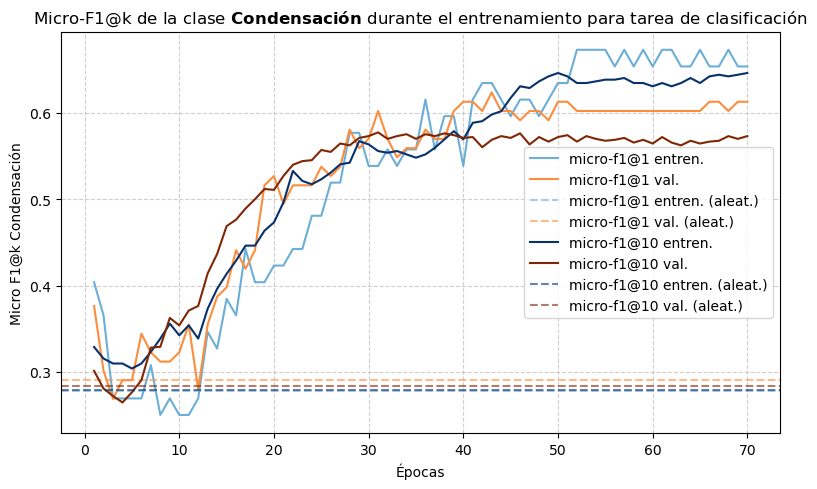

In [42]:
plot_train_val_scalars_with_random_baseline(

    ea,
    train_tags=['training_f1_condensacion@1', 'training_f1_condensacion@10'],
    val_tags=['validation_f1_condensacion@1', 'validation_f1_condensacion@10'],
    title="Micro-F1@k de la clase " + r"$\bf{" + "Condensación" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="Micro F1@k Condensación",
    train_labels=["micro-f1@1 entren.", "micro-f1@10 entren."],
    val_labels=["micro-f1@1 val.", "micro-f1@10 val."],
    random_train_tags=['training_f1_condensacion_random@1', 'training_f1_condensacion_random@10'],
    random_val_tags=['validation_f1_condensacion_random@1', 'validation_f1_condensacion_random@10']
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)  # blue shades
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)  # orange shades


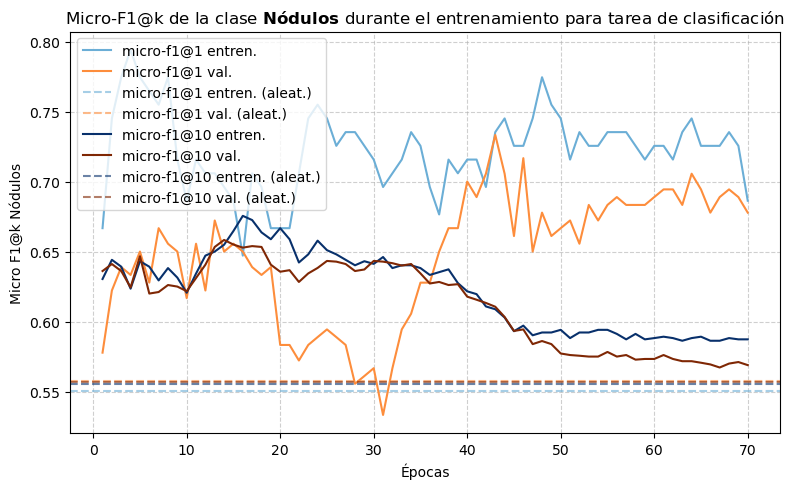

In [43]:
plot_train_val_scalars_with_random_baseline(

    ea,
    train_tags=['training_f1_nodulos@1', 'training_f1_nodulos@10'],
    val_tags=['validation_f1_nodulos@1', 'validation_f1_nodulos@10'],
    title="Micro-F1@k de la clase " + r"$\bf{" + "Nódulos" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="Micro F1@k Nódulos",
    train_labels=["micro-f1@1 entren.", "micro-f1@10 entren."],
    val_labels=["micro-f1@1 val.", "micro-f1@10 val."],
    random_train_tags=['training_f1_nodulos_random@1', 'training_f1_nodulos_random@10'],
    random_val_tags=['validation_f1_nodulos_random@1', 'validation_f1_nodulos_random@10']
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)  # blue shades
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)  # orange shades


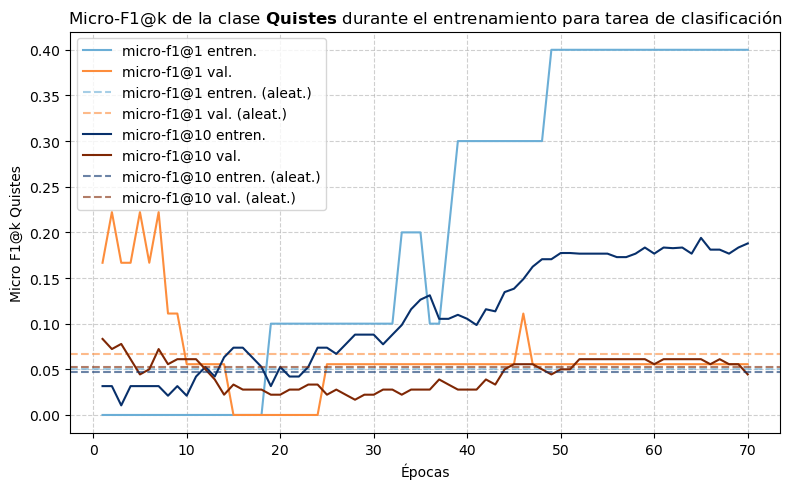

In [44]:
plot_train_val_scalars_with_random_baseline(

    ea,
    train_tags=['training_f1_quistes@1', 'training_f1_quistes@10'],
    val_tags=['validation_f1_quistes@1', 'validation_f1_quistes@10'],
    title="Micro-F1@k de la clase " + r"$\bf{" + "Quistes" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="Micro F1@k Quistes",
    train_labels=["micro-f1@1 entren.", "micro-f1@10 entren."],
    val_labels=["micro-f1@1 val.", "micro-f1@10 val."],
    random_train_tags=['training_f1_quistes_random@1', 'training_f1_quistes_random@10'],
    random_val_tags=['validation_f1_quistes_random@1', 'validation_f1_quistes_random@10']
)


# mAP

C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)  # blue shades
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\2842954144.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)  # orange shades


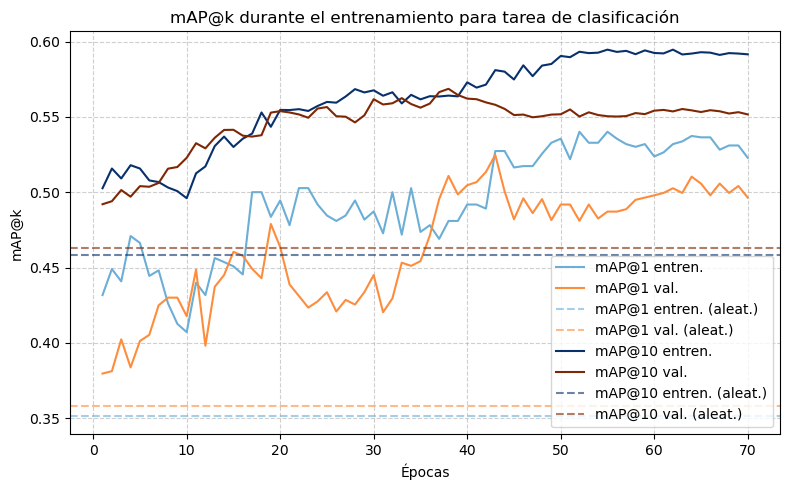

In [45]:
plot_train_val_scalars_with_random_baseline(
    ea,
    train_tags=['training_mean_average_precision@1', 'training_mean_average_precision@10'],
    val_tags=['validation_mean_average_precision@1', 'validation_mean_average_precision@10'],
    title="mAP@k durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="mAP@k",
    train_labels=["mAP@1 entren.", "mAP@10 entren."],
    val_labels=["mAP@1 val.", "mAP@10 val."],
    random_train_tags=['training_mean_average_precision_random@1', 'training_mean_average_precision_random@10'],
    random_val_tags=['validation_mean_average_precision_random@1', 'validation_mean_average_precision_random@10']
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\4033911722.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)  # blue shades
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\4033911722.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)  # orange shades


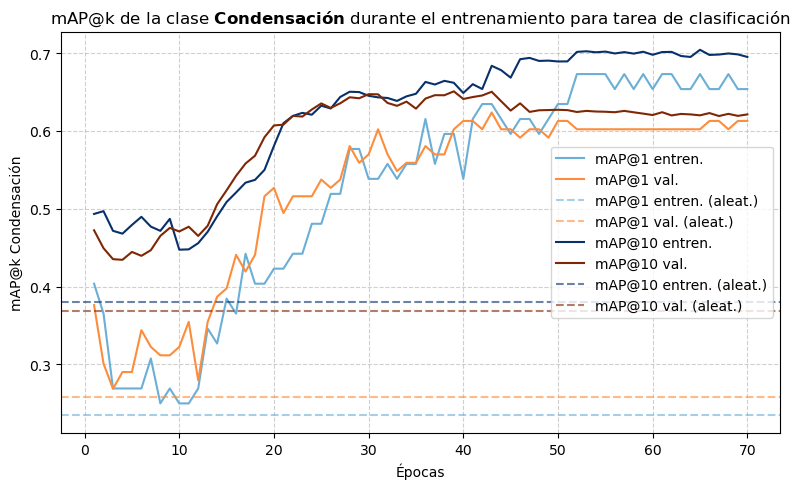

In [61]:
plot_train_val_scalars_with_random_baseline(
    ea,
    train_tags=['training_mean_average_precision_condensacion@1', 'training_mean_average_precision_condensacion@10'],
    val_tags=['validation_mean_average_precision_condensacion@1', 'validation_mean_average_precision_condensacion@10'],
    title="mAP@k de la clase " + r"$\bf{" + "Condensación" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="mAP@k Condensación",
    train_labels=["mAP@1 entren.", "mAP@10 entren."],
    val_labels=["mAP@1 val.", "mAP@10 val."],
    #random_train_tags=['training_mean_average_precision_condensacion_random@1', 'training_mean_average_precision_condensacion_random@10'],
    #random_val_tags=['validation_mean_average_precision_condensacion_random@1', 'validation_mean_average_precision_condensacion_random@10']
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\4033911722.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)  # blue shades
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\4033911722.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)  # orange shades


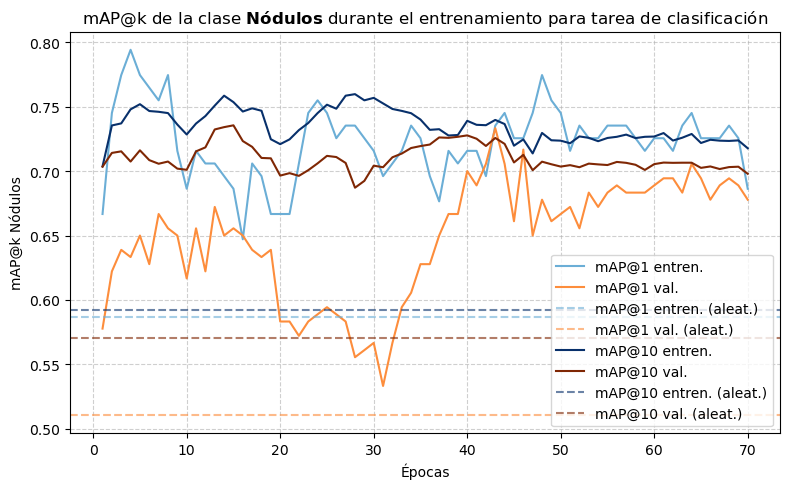

In [62]:
plot_train_val_scalars_with_random_baseline(
    ea,
    train_tags=['training_mean_average_precision_nodulos@1', 'training_mean_average_precision_nodulos@10'],
    val_tags=['validation_mean_average_precision_nodulos@1', 'validation_mean_average_precision_nodulos@10'],
    title="mAP@k de la clase " + r"$\bf{" + "Nódulos" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="mAP@k Nódulos",
    train_labels=["mAP@1 entren.", "mAP@10 entren."],
    val_labels=["mAP@1 val.", "mAP@10 val."],
    #random_train_tags=['training_mean_average_precision_nodulos_random@1', 'training_mean_average_precision_nodulos_random@10'],
    #random_val_tags=['validation_mean_average_precision_nodulos_random@1', 'validation_mean_average_precision_nodulos_random@10']
)


C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\4033911722.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  train_cmap = cm.get_cmap('Blues', n_metrics + 1)  # blue shades
C:\Users\jpmm\AppData\Local\Temp\ipykernel_15208\4033911722.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  val_cmap = cm.get_cmap('Oranges', n_metrics + 1)  # orange shades


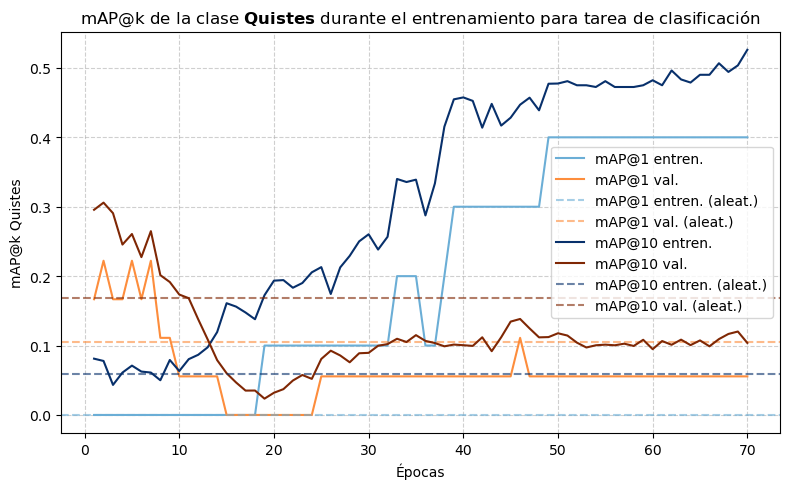

In [63]:
plot_train_val_scalars_with_random_baseline(
    ea,
    train_tags=['training_mean_average_precision_quistes@1', 'training_mean_average_precision_quistes@10'],
    val_tags=['validation_mean_average_precision_quistes@1', 'validation_mean_average_precision_quistes@10'],
    title="mAP@k de la clase " + r"$\bf{" + "Quistes" + "}$" + " durante el entrenamiento para tarea de clasificación",
    xlabel="Épocas",
    ylabel="mAP@k Quistes",
    train_labels=["mAP@1 entren.", "mAP@10 entren."],
    val_labels=["mAP@1 val.", "mAP@10 val."],
    #random_train_tags=['training_mean_average_precision_quistes_random@1', 'training_mean_average_precision_quistes_random@10'],
    #random_val_tags=['validation_mean_average_precision_quistes_random@1', 'validation_mean_average_precision_quistes_random@10']
)


In [20]:
def summarize_scalars(ea, scalar_tags = None, loss_tags=("train_loss", "validation_loss")):
    """
    Summarizes scalar metrics from an EventAccumulator.

    - Loss metrics: min value & step + last value/step.
    - Random metrics (name contains 'random'): average value + last value/step.
    - Other metrics: max value & step + last value/step.

    Parameters
    ----------
    ea : EventAccumulator
        Loaded EventAccumulator for the events file.
    scalar_tags : list[str]
        Scalar tags to summarize.
    loss_tags : tuple[str]
        Tags that should be treated as losses (find minimum instead of maximum).

    Returns
    -------
    dict
        {
          tag: {
            "summary_value": float,
            "summary_step": int or None,
            "last_value": float,
            "last_step": int
          }
        }
        - summary_value is min, max, or average depending on tag type.
        - summary_step is None for average (random) metrics.
    """
    results = {}

    if scalar_tags is None:
        scalar_tags = ea.Tags()['scalars']
    for tag in scalar_tags:
        events = ea.Scalars(tag)
        if not events:
            results[tag] = None
            continue

        steps = [e.step for e in events]
        values = [e.value for e in events]

        if "random" in tag.lower():
            # Random metric → average
            summary_value = sum(values) / len(values)
            summary_step = None
        elif tag in loss_tags:
            # Loss metric → minimum
            idx = min(range(len(values)), key=lambda i: values[i])
            summary_value = values[idx]
            summary_step = steps[idx]
        else:
            # Normal metric → maximum
            idx = max(range(len(values)), key=lambda i: values[i])
            summary_value = values[idx]
            summary_step = steps[idx]

        last_value = values[-1]
        last_step = steps[-1]

        results[tag] = {
            "summary_value": summary_value,
            "summary_step": summary_step,
            "last_value": last_value,
            "last_step": last_step
        }

    return results


In [23]:
metrics = [
    "training_loss", "validation_loss",
    "training_f1@1", "validation_f1@1",
    "training_precision_random@10", "validation_precision_random@10"
]

summary = summarize_scalars(ea, metrics)

for tag, info in summary.items():
    if "random" in tag.lower():
        print(f"{tag}: avg = {info['summary_value']:.4f}, last = {info['last_value']:.4f} (step {info['last_step']})")
    else:
        print(f"{tag}: summary = {info['summary_value']:.4f} at step {info['summary_step']}, last = {info['last_value']:.4f} (step {info['last_step']})")


training_loss: summary = 0.8091 at step 1, last = 0.7503 (step 70)
validation_loss: summary = 0.7688 at step 68, last = 0.7688 (step 70)
training_f1@1: summary = 0.5401 at step 52, last = 0.5228 (step 70)
validation_f1@1: summary = 0.5247 at step 43, last = 0.4964 (step 70)
training_precision_random@10: avg = 0.3556, last = 0.3472 (step 70)
validation_precision_random@10: avg = 0.3580, last = 0.3444 (step 70)
